In [36]:
import os
import importlib

import cfGPR
import vonkarmanFT as vk
import plotGPR

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy.optimize as opt
from scipy.spatial.ckdtree import cKDTree

In [2]:
importlib.reload(vk)

<module 'vonkarmanFT' from '/home/fortino/DESworkspace/vonkarmanFT.py'>

In [3]:
def getGrid(X1, X2):
    u1, u2 = X1[:, 0], X2[:, 0]
    v1, v2 = X1[:, 1], X2[:, 1]
    uu1, uu2 = np.meshgrid(u1, u2)
    vv1, vv2 = np.meshgrid(v1, v2)
    
    return uu1 - uu2, vv1 - vv2

In [4]:
def fit_vonKarman(X, variance, outerScale, diameter, wind_x, wind_y):
    
    theta = {
        'var': variance,
        'oS': outerScale,
        'd': diameter,
        'wind_x': wind_x,
        'wind_y': wind_y
    }
    params = ' '.join(
        [f"{name:>8}: {x:<9.6f}" for name, x in theta.items()])
#     with open("params.out", mode='a+') as file:
#         file.write(params + '\n')
    print(params)
    
    # Undo formatting of the grid.
    xx = X[0].reshape((int(np.sqrt(X[0].shape[0])),
                       int(np.sqrt(X[0].shape[0]))))
    yy = X[1].reshape((int(np.sqrt(X[1].shape[0])),
                       int(np.sqrt(X[1].shape[0]))))
    
    ttt = vk.TurbulentLayer(
        variance=variance,
        outerScale=outerScale,
        diameter=diameter,
        wind=(wind_x, wind_y))
    
    # Caulculate covariance function, xi_plus, and return it.
    Cuv = ttt.getCuv(xx, yy)
    xiplus = Cuv[:, :, 0, 0] + Cuv[:, :, 1, 1]
    xiplus = np.where(np.isnan(xiplus), 0, xiplus)
    
    return xiplus.ravel(order='C')

/home/fortino/DESworkspace/plotGPR.py:834: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_x / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:838: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_y / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:842: RuntimeWarning: divide by zero encountered in reciprocal
  sumWeights**-1.,
/home/fortino/DESworkspace/plotGPR.py:853: RuntimeWarning: invalid value encountered in less
  sumWeights < (maxErr**2.).value)
/home/fortino/DESworkspace/plotGPR.py:860: RuntimeWarning: invalid value encountered in greater
  RMS_x = np.std(sumWeights_x[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:861: RuntimeWarning: invalid value encountered in greater
  RMS_y = np.std(sumWeights_y[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:862: RuntimeWarning: invalid value encountered in greater
  noise = np.sqrt(np.mean(sumWeights[sumWeights > 0.]))*u.mas


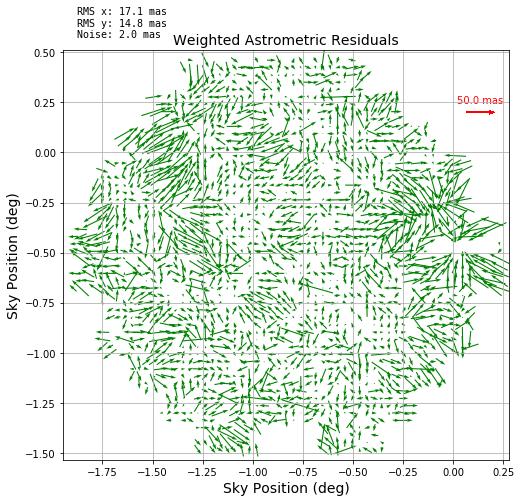

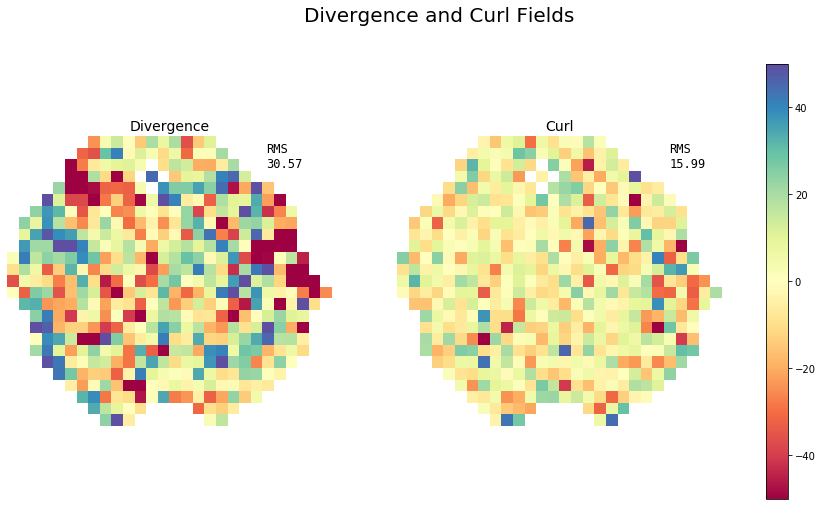

4069 Stars Evaluated...
For the first 39 separation bins...
                    E-Mode    B-Mode    xi_+      
Mean Observed       429.594   -6.812    422.782   
Std  Observed       131.267   143.783   190.879   



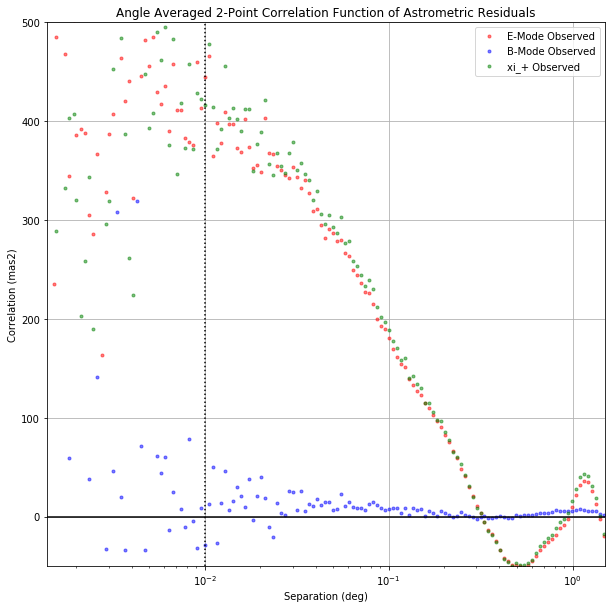

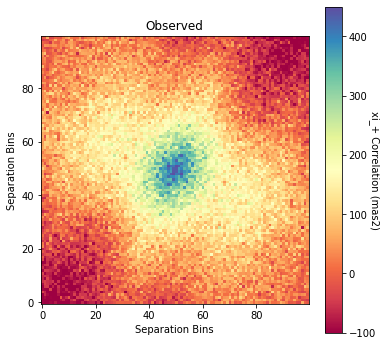

In [19]:
GP = cfGPR.CurlFreeGPR()
GP.load_fits("folio2")
GP.extract_data(465)
GP.sigma_clip()
GP.split_data(train_size=0.50)

x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

plotGPR.AstrometricResiduals(x, y, dx, dy, err)
plotGPR.DivCurl(x, y, dx, dy, err)
plotGPR.Correlation(x, y, dx, dy, xiplus_ON=True)
plotGPR.Correlation2D(x, y, dx, dy)

In [15]:
bounds = np.array([
    (1, 1000),
    (0.1, 5),
    (0.01, 0.25),
    (-3, 3),
    (-3, 3),
]).T

In [181]:
rmax = 5*u.arcmin
nBins = 50

xiplus = plotGPR.calcCorrelation2D(x, y, dx, dy, rmax=rmax, nBins=nBins)[0]
xiplus = np.where(np.isnan(xiplus), 0, xiplus)
# xiplus_ravel = xiplus.ravel(order='C')

In [22]:
dx = (rmax / (nBins / 2)).to(u.deg).value
x = np.arange(-nBins / 2, nBins / 2) * dx
xx, yy = np.meshgrid(x, x)

def figureOfMerit(params):
    ttt = vk.TurbulentLayer(
        variance=params[0],
        outerScale=params[1],
        diameter=params[2],
        wind=(params[3], params[4]))
    
    Cuv = ttt.getCuv(xx, yy)
    xiplus_model = Cuv[:, :, 0, 0] + Cuv[:, :, 1, 1]
    xiplus_model = np.where(np.isnan(xiplus_model), 0, xiplus_model)
    
    chisq = np.mean((xiplus - xiplus_model)**2)
    
    theta = {
        "fom": chisq,
        'var': params[0],
        'oS': params[1],
        'd': params[2],
        'wind_x': params[3],
        'wind_y': params[4]
    }
    theta = ' '.join(
        [f"{name:>8}: {x:<9.6f}" for name, x in theta.items()]
    )
    print(theta)
    
    return chisq

In [10]:
v0 = np.array([
    500,
    1,
    0.1,
    0.05,
    0.05
])

# # Starting params for exposure 466
# v0 = np.array([
#     445.894365,
#     1.711410,
#     0.115865,
#     0.019856,
#     0.075538
# ])

simplex0 = np.vstack([v0, np.vstack([v0]*5) + np.diag(v0*0.15)])


options = {
    "initial_simplex": simplex0,
    "fatol": 25,
    "xatol": 5
}

opt_result = opt.minimize(
    figureOfMerit,
    simplex0[0],
    method='Nelder-Mead',
    options=options
)

/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: divide by zero encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: invalid value encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: divide by zero encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: invalid value encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)


     fom: 6768.745569      var: 500.000000       oS: 1.000000         d: 0.100000    wind_x: 0.050000    wind_y: 0.050000 
     fom: 13040.181822      var: 575.000000       oS: 1.000000         d: 0.100000    wind_x: 0.050000    wind_y: 0.050000 
     fom: 7216.635355      var: 500.000000       oS: 1.150000         d: 0.100000    wind_x: 0.050000    wind_y: 0.050000 
     fom: 8143.649300      var: 500.000000       oS: 1.000000         d: 0.115000    wind_x: 0.050000    wind_y: 0.050000 
     fom: 6907.513749      var: 500.000000       oS: 1.000000         d: 0.100000    wind_x: 0.057500    wind_y: 0.050000 
     fom: 6854.323380      var: 500.000000       oS: 1.000000         d: 0.100000    wind_x: 0.050000    wind_y: 0.057500 
     fom: 4671.113041      var: 425.000000       oS: 1.060000         d: 0.106000    wind_x: 0.053000    wind_y: 0.053000 
     fom: 6168.741556      var: 350.000000       oS: 1.090000         d: 0.109000    wind_x: 0.054500    wind_y: 0.054500 
     fom: 5357.

In [11]:
opt_result

 final_simplex: (array([[3.77403243e+02, 1.55965199e+00, 9.89875236e-02, 7.09424548e-02,
        1.09184000e-01],
       [3.80313185e+02, 1.45080258e+00, 1.03505634e-01, 6.83336764e-02,
        9.64493497e-02],
       [3.81184063e+02, 1.48825571e+00, 1.00155256e-01, 7.30695616e-02,
        1.04090953e-01],
       [3.77248344e+02, 1.50939603e+00, 1.01255305e-01, 7.23062518e-02,
        1.02677669e-01],
       [3.75013967e+02, 1.50286490e+00, 1.02374382e-01, 7.33602216e-02,
        1.07649881e-01],
       [3.79729778e+02, 1.44540686e+00, 1.08646549e-01, 6.63981895e-02,
        9.46889137e-02]]), array([4220.14574524, 4222.22295486, 4223.62268914, 4225.28712561,
       4231.59974649, 4231.63530635]))
           fun: 4220.14574523958
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 63
        status: 0
       success: True
             x: array([3.77403243e+02, 1.55965199e+00, 9.89875236e-02, 7.09424548e-02,
       1.09184000e-01])

In [182]:
# Initialize a von Karman model with the parameters from the optimizer.
ttt = vk.TurbulentLayer(
    variance=opt_result.x[0],
    outerScale=opt_result.x[1],
    diameter=opt_result.x[2],
    wind=(opt_result.x[3], opt_result.x[4]))

# Evaluate the covariance function on a grid for plotting.
Cuv_model = ttt.getCuv(xx, yy)
xiplus_model = Cuv_model[:, :, 0, 0] + Cuv_model[:, :, 1, 1]

Text(0.5, 1.0, 'Residuals')

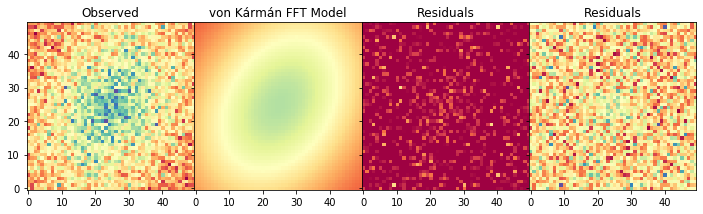

In [183]:
# Plot the 2pt correlation function of the observed data, the fitted model, the difference of the two,
# and a closeup of the difference. This helps evaluate the fit.
fig, axes = plt.subplots(
    nrows=1, ncols=4,
    sharex=True, sharey=True,
    figsize=(12, 6))
fig.subplots_adjust(wspace=0)

im = axes[0].imshow(
    xiplus,
    origin='lower', cmap='Spectral', interpolation='nearest',
    vmin=xiplus.min(), vmax=xiplus.max())
axes[0].set_title("Observed")

im = axes[1].imshow(
    xiplus_model,
    origin='lower', cmap='Spectral', interpolation='nearest',
    vmin=xiplus.min(), vmax=xiplus.max())
axes[1].set_title("von Kármán FFT Model")

im = axes[2].imshow(
    xiplus - xiplus_model,
    origin='lower', cmap='Spectral', interpolation='nearest',
    vmin=xiplus.min(), vmax=xiplus.max())
axes[2].set_title("Residuals")
# fig.colorbar(im, ax=axes[2])

im = axes[3].imshow(
    xiplus - xiplus_model,
    origin='lower', cmap='Spectral', interpolation='nearest')
axes[3].set_title("Residuals")
# fig.colorbar(im, ax=axes[3])

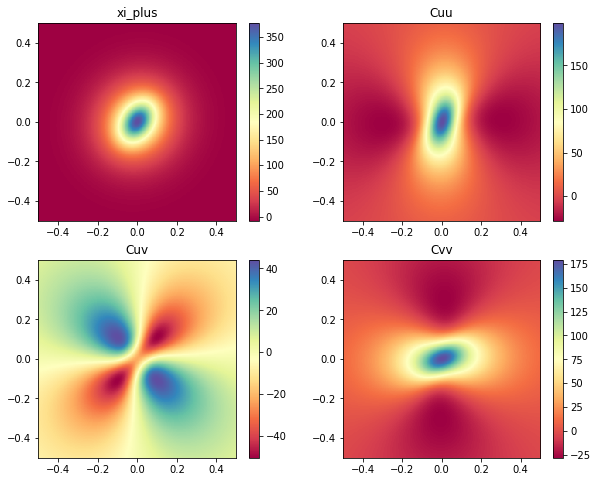

In [184]:
vk.plotCuv(ttt)

In [185]:
du, dv = getGrid(GP.Xtrain, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
n1, n2 = Cuv.shape[0], Cuv.shape[1]
K = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

In [186]:
du, dv = getGrid(GP.Xtest, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
n1, n2 = Cuv.shape[0], Cuv.shape[1]
Ks = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

In [187]:
W = GP.white_noise_kernel(GP.Etrain)

In [188]:
L = np.linalg.cholesky(K + W)

In [189]:
alpha = np.linalg.solve(L.T, np.linalg.solve(L, GP.flat(GP.Ytrain)))

In [190]:
GP.fbar_s = GP.unflat(np.dot(Ks.T, alpha))

In [191]:
x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

x2 = GP.Xtest[:, 0]*u.deg
y2 = GP.Xtest[:, 1]*u.deg
dx2 = GP.Ytest[:, 0]*u.mas - GP.fbar_s[:, 0]*u.mas
dy2 = GP.Ytest[:, 1]*u.mas - GP.fbar_s[:, 1]*u.mas
err2 = GP.Etest[:, 0]*u.mas

/home/fortino/DESworkspace/plotGPR.py:834: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_x / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:838: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_y / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:842: RuntimeWarning: divide by zero encountered in reciprocal
  sumWeights**-1.,
/home/fortino/DESworkspace/plotGPR.py:853: RuntimeWarning: invalid value encountered in less
  sumWeights < (maxErr**2.).value)
/home/fortino/DESworkspace/plotGPR.py:860: RuntimeWarning: invalid value encountered in greater
  RMS_x = np.std(sumWeights_x[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:861: RuntimeWarning: invalid value encountered in greater
  RMS_y = np.std(sumWeights_y[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:862: RuntimeWarning: invalid value encountered in greater
  noise = np.sqrt(np.mean(sumWeights[sumWeights > 0.]))*u.mas


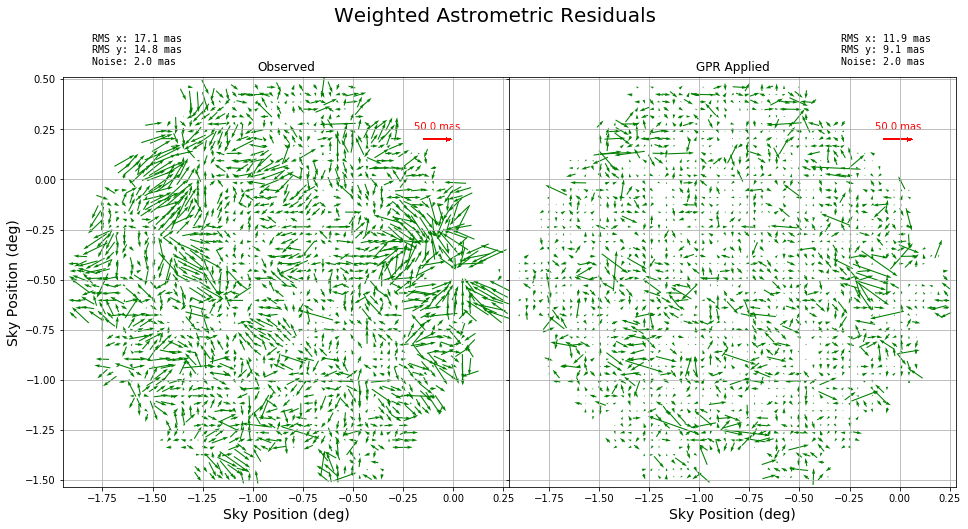

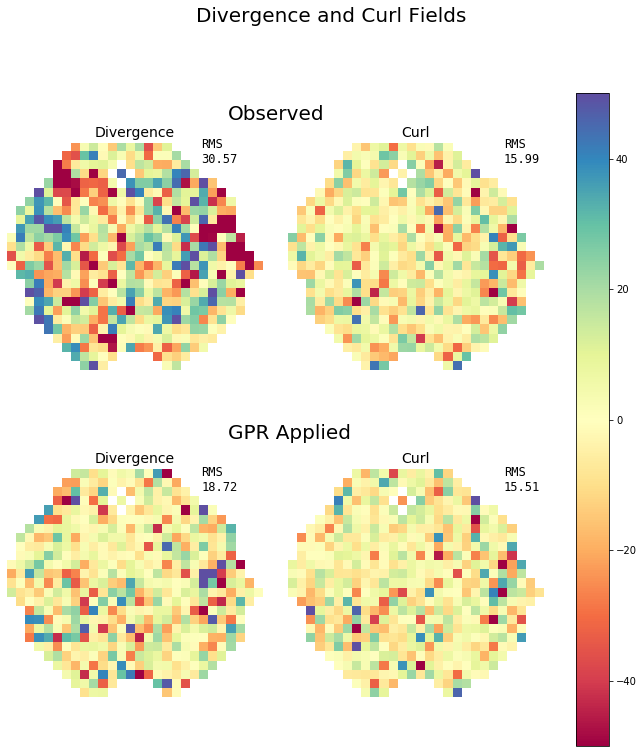

4069 Stars Evaluated...
For the first 39 separation bins...
                    E-Mode    B-Mode    xi_+      
Mean Observed       429.594   -6.812    422.782   
Mean GPR Applied    109.708   9.694     119.402   

Std  Observed       131.267   143.783   190.879   
Std  GPR Applied    43.999    29.547    60.79     

Mean Ratio          3.916     0.703     3.541     


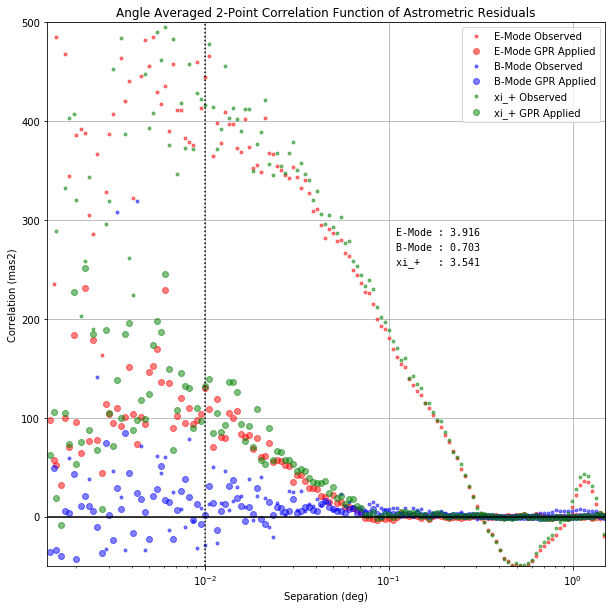

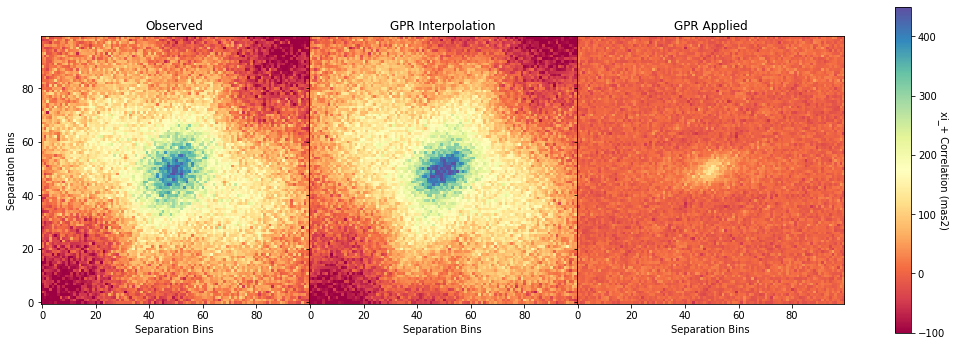

In [192]:
plotGPR.AstrometricResiduals(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2)

plotGPR.DivCurl(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2)

plotGPR.Correlation(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    xiplus_ON=True)

plotGPR.Correlation2D(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2)

In [170]:
def figureOfMeritGP(params):
    ttt = vk.TurbulentLayer(
        variance=params[0],
        outerScale=params[1],
        diameter=params[2],
        wind=(params[3], params[4]))

    du, dv = getGrid(GP.Xtrain, GP.Xtrain)
    Cuv = ttt.getCuv(du, dv)
    n1, n2 = Cuv.shape[0], Cuv.shape[1]
    K = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

    du, dv = getGrid(GP.Xtest, GP.Xtrain)
    Cuv = ttt.getCuv(du, dv)
    n1, n2 = Cuv.shape[0], Cuv.shape[1]
    Ks = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)
    
    W = GP.white_noise_kernel(GP.Etrain)
    
    L = np.linalg.cholesky(K + W)
    
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, GP.flat(GP.Ytrain)))
    
    GP.fbar_s = GP.unflat(np.dot(Ks.T, alpha))
    
    res = GP.Ytest - GP.fbar_s
    rMax = (0.2*u.deg).to(u.deg).value
    rMin = (5*u.mas).to(u.deg).value
    r = np.linspace(rMin, rMax, 100)
    kdt = cKDTree(GP.Xtest)
    xiplus = np.zeros(r.shape)
    for i, radius in enumerate(r):
        prsmax = kdt.query_pairs(r[i], output_type='ndarray')
        xiplus[i] = np.nanmean(res[prsmax][:, 0, :] * res[prsmax][:, 1, :])
    xiplus = np.nanmean(xiplus)
    
    theta = {
        "xiplus": xiplus,
        'var': params[0],
        'oS': params[1],
        'd': params[2],
        'wind_x': params[3],
        'wind_y': params[4]
    }
    theta = ' '.join(
        [f"{name:>8}: {x:<10.6f}" for name, x in theta.items()])
    with open("params.out", mode="a+") as file:
        file.write(theta + "\n")
    print(theta)
    
    return xiplus

In [175]:
if os.path.exists("params.out"):
    os.remove("params.out")
v0 = opt_result.x
v0 = np.array([
    532.812126,
    2.036610,
    0.051416,
    0.024977,
    0.164207
])
simplex0 = np.vstack([v0, np.vstack([v0]*5) + np.diag(v0*0.15)])

options = {
    "initial_simplex": simplex0,
    "fatol": 0.01,
    "xatol": 0.001
}

opt_result_GP = opt.minimize(
    figureOfMeritGP,
    simplex0[0],
    method='Nelder-Mead',
    options=options
)

/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: divide by zero encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: invalid value encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: divide by zero encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: invalid value encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)
/home/fortino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


  xiplus: 11.637607       var: 532.812126       oS: 2.036610          d: 0.051416     wind_x: 0.024977     wind_y: 0.164207  
  xiplus: 11.515780       var: 612.733945       oS: 2.036610          d: 0.051416     wind_x: 0.024977     wind_y: 0.164207  
  xiplus: 11.692112       var: 532.812126       oS: 2.342102          d: 0.051416     wind_x: 0.024977     wind_y: 0.164207  
  xiplus: 12.214113       var: 532.812126       oS: 2.036610          d: 0.059128     wind_x: 0.024977     wind_y: 0.164207  
  xiplus: 11.414456       var: 532.812126       oS: 2.036610          d: 0.051416     wind_x: 0.028724     wind_y: 0.164207  
  xiplus: 12.199214       var: 532.812126       oS: 2.036610          d: 0.051416     wind_x: 0.024977     wind_y: 0.188838  
  xiplus: 11.919722       var: 564.780854       oS: 2.158807          d: 0.043704     wind_x: 0.026476     wind_y: 0.174059  
  xiplus: 11.187975       var: 577.568345       oS: 2.207685          d: 0.048331     wind_x: 0.027075     wind_y: 0.1

In [176]:
x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

x2 = GP.Xtest[:, 0]*u.deg
y2 = GP.Xtest[:, 1]*u.deg
dx2 = GP.Ytest[:, 0]*u.mas - GP.fbar_s[:, 0]*u.mas
dy2 = GP.Ytest[:, 1]*u.mas - GP.fbar_s[:, 1]*u.mas
err2 = GP.Etest[:, 0]*u.mas

/home/fortino/DESworkspace/plotGPR.py:834: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_x / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:838: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_y / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:842: RuntimeWarning: divide by zero encountered in reciprocal
  sumWeights**-1.,
/home/fortino/DESworkspace/plotGPR.py:853: RuntimeWarning: invalid value encountered in less
  sumWeights < (maxErr**2.).value)
/home/fortino/DESworkspace/plotGPR.py:860: RuntimeWarning: invalid value encountered in greater
  RMS_x = np.std(sumWeights_x[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:861: RuntimeWarning: invalid value encountered in greater
  RMS_y = np.std(sumWeights_y[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:862: RuntimeWarning: invalid value encountered in greater
  noise = np.sqrt(np.mean(sumWeights[sumWeights > 0.]))*u.mas


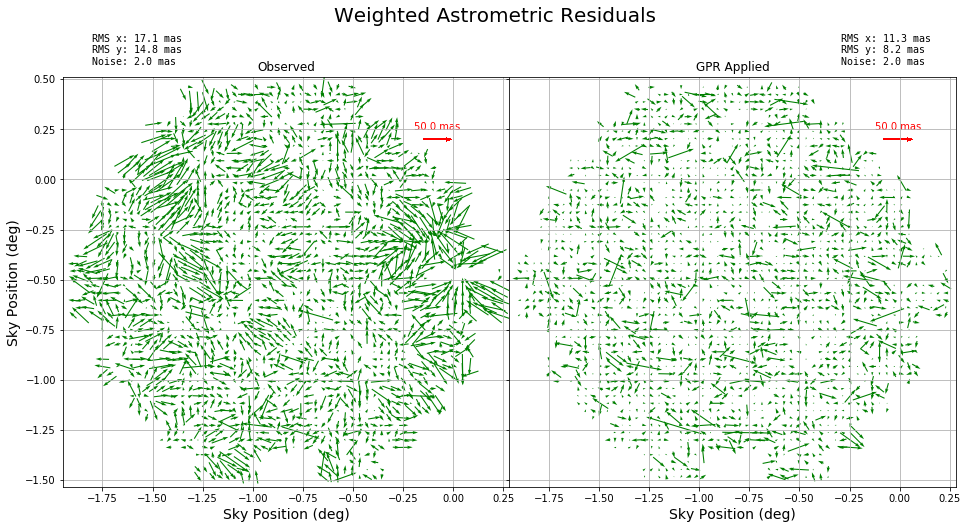

/home/fortino/DESworkspace/plotGPR.py:834: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_x / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:838: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_y / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:842: RuntimeWarning: divide by zero encountered in reciprocal
  sumWeights**-1.,
/home/fortino/DESworkspace/plotGPR.py:853: RuntimeWarning: invalid value encountered in less
  sumWeights < (maxErr**2.).value)
/home/fortino/DESworkspace/plotGPR.py:860: RuntimeWarning: invalid value encountered in greater
  RMS_x = np.std(sumWeights_x[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:861: RuntimeWarning: invalid value encountered in greater
  RMS_y = np.std(sumWeights_y[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:862: RuntimeWarning: invalid value encountered in greater
  noise = np.sqrt(np.mean(sumWeights[sumWeights > 0.]))*u.mas


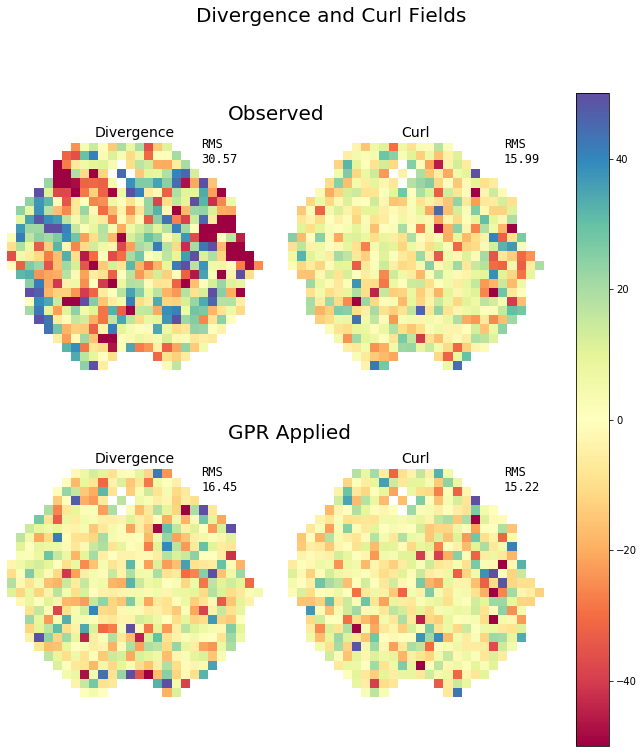

4069 Stars Evaluated...
For the first 39 separation bins...
                    E-Mode    B-Mode    
Mean Observed       429.594   -6.812    
Mean GPR Applied    82.218    10.495    

Std  Observed       131.267   143.783   
Std  GPR Applied    43.003    33.957    

Mean Ratio          5.225     0.649     


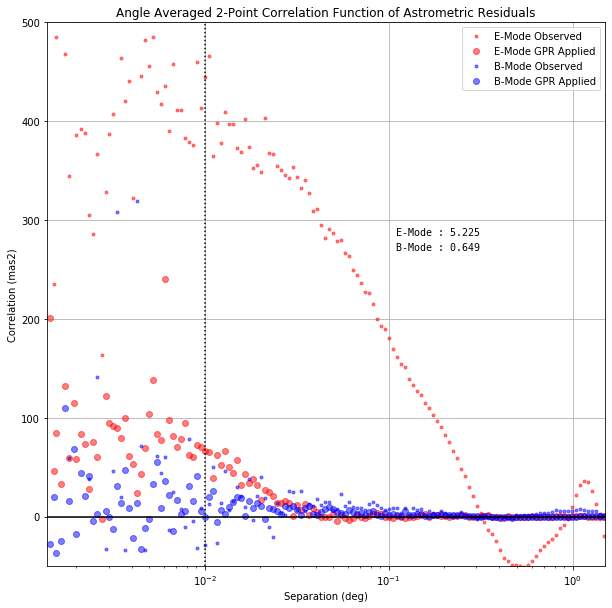

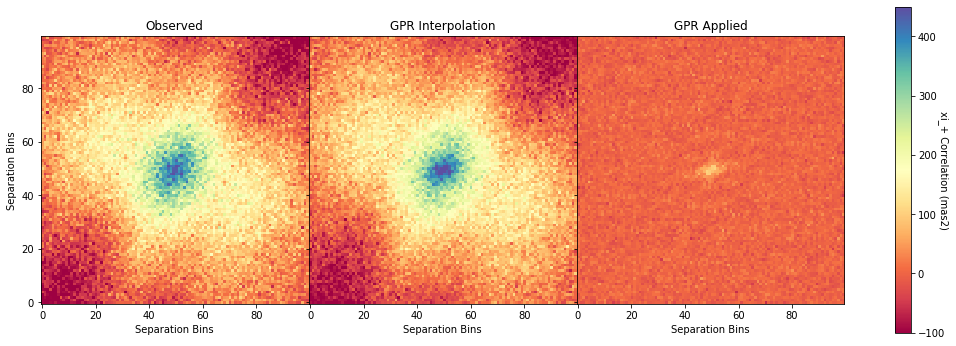

In [177]:
plotGPR.AstrometricResiduals(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    savePath=".")

plotGPR.DivCurl(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    savePath=".")

plotGPR.Correlation(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    savePath=".")

plotGPR.Correlation2D(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    savePath=".")